In [26]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, EarlyStoppingCallback, MBartConfig
from transformers import MBartForConditionalGeneration, MBartTokenizerFast,MBartTokenizer,Trainer, TrainingArguments

from transformers import DataCollatorForSeq2Seq
from hftrim.TokenizerTrimmer import TokenizerTrimmer
from hftrim.ModelTrimmers import MBartTrimmer

from transformers import PreTrainedTokenizerFast
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
from datasets import concatenate_datasets
from datasets import Dataset
from random import randrange
import evaluate
import nltk
import numpy as np
import pandas as pd
from collections import Counter
from lsg_converter import LSGConverter
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/risto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# !pip install peft

In [4]:
# !pip install nltk

In [5]:
# !pip install evaluate

In [6]:
# !pip install rouge_score

In [7]:
# !pip install py7zr

In [8]:
# !pip install transformers --upgrade

## model

In [3]:
model_id="facebook/mbart-large-cc25"
src_lang = "et_EE" # Example source language code
tgt_lang = "et_EE" # Example target language code

In [25]:
tokenizer = MBartTokenizerFast.from_pretrained(model_id)
tokenizer_slow = MBartTokenizer.from_pretrained(model_id)
model = MBartForConditionalGeneration.from_pretrained(model_id)

In [26]:
# Important: Set both source and target languages
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

tokenizer_slow.src_lang = src_lang
tokenizer_slow.tgt_lang = tgt_lang

In [27]:
def msize(m):
    return sum(p.numel() for p in m.parameters())
#share of params in embedding
print(msize(model.model.shared) / msize(model))   
print(msize(model.lm_head) / msize(model))  

0.41913215486098887
0.41913215486098887


## data

In [27]:
dataset_id = "riigikogu"
df=pd.read_excel('data/riigikogu/for_summarization_mbart_2048_chunks_summaries.xlsx')
df_train=df[df.split=='train']
df_test=df[df.split=='test']

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3516
Test dataset size: 308


In [28]:
train_dataset=train_dataset.filter(lambda example, idx: example['summary'] is not None and example['text'] is not None, with_indices=True)
test_dataset = test_dataset.filter(lambda example, idx: example['summary'] is not None and example['text'] is not None, with_indices=True)

Filter:   0%|          | 0/3516 [00:00<?, ? examples/s]

Filter:   0%|          | 0/308 [00:00<?, ? examples/s]

In [29]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3516
Test dataset size: 308


## trim models vocab

In [39]:
texts4vocab=train_dataset['text']+train_dataset['summary']
len(texts4vocab)

7032

In [40]:
config = MBartConfig.from_pretrained(model_id)

In [41]:
# trim tokenizer
tokenizer_slow_trim = TokenizerTrimmer(tokenizer_slow)
tokenizer_slow_trim.make_vocab(texts4vocab)
tokenizer_slow_trim.make_tokenizer()

# trim model
model_trim = MBartTrimmer(model, config, tokenizer_slow_trim.trimmed_tokenizer)
model_trim.make_weights(tokenizer_slow_trim.trimmed_vocab_ids)
model_trim.make_model()

Token indices sequence length is longer than the specified maximum sequence length for this model (1359 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 250000/250000 [00:00<00:00, 1141163.13it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(16273, 1024, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(16273, 1024, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0): MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNor

## Save trimmed model and tokenizer

In [42]:
tokenizer_slow_trim.trimmed_tokenizer.save_pretrained('mbart-large-cc25_et_rk')
model_trim.trimmed_model.save_pretrained('mbart-large-cc25_et_rk')

## Load model and tokenizer

In [13]:
tokenizer = MBartTokenizerFast.from_pretrained("mbart-large-cc25_et_rk/", from_slow=True)
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
model = MBartForConditionalGeneration.from_pretrained('mbart-large-cc25_et_rk', max_length=1024)

## Load model and make it accepting longer sequences

In [20]:
converter = LSGConverter(max_sequence_length=2048)

model_id='mbart-large-cc25_et_rk'
model, tokenizer = converter.convert_from_pretrained(model_id, num_global_tokens=7)
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang
print(type(model))

/home/risto/.local/lib/python3.9/site-packages/transformers/models/auto/configuration_auto.py:1067: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/risto/.local/lib/python3.9/site-packages/transformers/configuration_utils.py:508: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/home/risto/.local/lib/python3.9/site-packages/transformers/modeling_utils.py:2759: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Some weights of LSGMBartForConditionalGeneration were not initialized from the 

<class 'lsg_converter.mbart.modeling_lsg_mbart.LSGMBartForConditionalGeneration'>


In [46]:
model.save_pretrained('mbart-large-cc25_lsg_2048_et_rk_text')

In [47]:
tokenizer.save_pretrained('mbart-large-cc25_lsg_2048_et_rk_text')

('/opt/work/storage2/localdata/datasience_dev/text/summarization/transformers/mbart-large-cc25_lsg_2048_et_rk/tokenizer_config.json',
 '/opt/work/storage2/localdata/datasience_dev/text/summarization/transformers/mbart-large-cc25_lsg_2048_et_rk/special_tokens_map.json',
 '/opt/work/storage2/localdata/datasience_dev/text/summarization/transformers/mbart-large-cc25_lsg_2048_et_rk/sentencepiece.bpe.model',
 '/opt/work/storage2/localdata/datasience_dev/text/summarization/transformers/mbart-large-cc25_lsg_2048_et_rk/added_tokens.json',
 '/opt/work/storage2/localdata/datasience_dev/text/summarization/transformers/mbart-large-cc25_lsg_2048_et_rk/tokenizer.json')

## prep data for training

In [7]:
max_source_length = 2048

In [8]:
max_target_length=512

In [56]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = [item for item in sample["text"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text=sample["summary"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [59]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["text", "summary"])

Map:   0%|          | 0/3516 [00:00<?, ? examples/s]

In [60]:
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["text", "summary"])

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

## evaluator

In [8]:
# Metric
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [62]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

## training 

In [63]:
early_stop = EarlyStoppingCallback(3, 0.0)

In [64]:
#save to other disc where chmod is supported
repository_id = f"mbart-large-cc25_lsg_2048_et_riigikogu/{dataset_id}_text"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=2,
    predict_with_generate=True,
    fp16=True,
    learning_rate=5e-5,
    num_train_epochs=10,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=repository_id,
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

/home/risto/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train()

You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


## calculate metrics

In [30]:
model_id="mbart-large-cc25_lsg_2048_et_riigikogu/riigikogu_text/checkpoint-5274/"
tokenizer = MBartTokenizerFast.from_pretrained('mbart-large-cc25_lsg_2048_et_rk_text',
                                               from_slow=True)
model = MBartForConditionalGeneration.from_pretrained(model_id)

In [31]:
model=model.to('cuda')

In [10]:
def calc_texts_labels_metrics(texts, summaries, model, tokenizer, max_input_length=2048, max_output_length=512, batch_size = 10):
    true_labels=tokenizer(
        summaries, return_tensors="pt",padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids.cpu()
    input_ids = tokenizer(
        texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids  
    
    predictions = []
    for i in range(0, input_ids.size(0), batch_size):
        batch_input_ids = input_ids[i:i + batch_size].to('cuda')
        batch_outputs = model.generate(input_ids=batch_input_ids, max_length=max_output_length)
        predictions.extend(batch_outputs.cpu().detach().numpy())
    max_length = max(len(p) for p in predictions)
    padded_predictions = [np.pad(p, (0, max_length - len(p)), mode='constant') for p in predictions]
    outputs = torch.tensor(padded_predictions)
    eval_preds = (outputs, true_labels.cpu())
    metrics = compute_metrics(eval_preds)
    return metrics

In [11]:
eval_metrics=calc_texts_labels_metrics(df_test.text.tolist(), df_test.summary.tolist(), model, tokenizer)
eval_metrics

/tmp/ipykernel_43869/637517378.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  outputs = torch.tensor(padded_predictions)


{'rouge1': 27.9854,
 'rouge2': 9.8125,
 'rougeL': 19.8103,
 'rougeLsum': 24.7255,
 'gen_len': 465.29545454545456}

## example usage

In [12]:
def summarize(text, model, tokenizer, max_input_length=2048, max_new_tokens=512):
    input_ids = tokenizer(
         text, return_tensors="pt",
        max_length=max_input_length
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to('cuda'), max_new_tokens=max_new_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [13]:
summarize(df_test.text.tolist()[0], model, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


- Sven Sester annab ülevaate riigieelarve seaduse eelnõust ja muudatustest - Sotsiaaldemokraatlik Erakond esitab mitmeid muudatusettepanekuid seoses riigieelarve koostamise ja tasakaalustamisega


In [14]:
summarize(df_test.text.tolist()[1], model, tokenizer)

- Sven Sester selgitab lühiajalist laenu võtmise tingimusi ja Eesti Panga hinnangut. - Muudatusettepanekud riigi eelarvestrateegia ja kriisiolukordade kohta.


In [15]:
input_text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti. 
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""
summarize(input_text, model, tokenizer)

- Soome kõige populaarsem partei Koonderakond kaotas märtsis tiitli SDP-le, peaministripartei toetus langes ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti. - SDP suurendas toetust naiste ja noorte hulgas, erakondi kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus ning erakonna toetus on 17,4 protsenti.


In [16]:
summarize(df_test.text.tolist()[2], model, tokenizer)

- Sven Sester soovitab riigi eelarvestrateegiat arutada Riigikogus - Oluline on tagada eelarve täitmise aruandes esitatud arvandmed ja täpsed nõuded valitsuse esitatavate tegevuskavade ning stabiliseerimisreservi moodustamise ja kasutamise kohta - Komisjon langetas konsensuslikud otsused seoses töötuskindlustusmakse muudatustega riigieelarve seaduse eelnõus


In [17]:
summarize(df_test.text.tolist()[3], model, tokenizer)

- Põhiseaduskomisjoni esimees Jaak Allik juhib põhiseaduskomisjoni täiendavate küsimuste tähelepanu. - Aseesimees Laine Randjärv suunab täiendavate küsimuste esitamise juurde. - Kalev Kotkas ja Rannar Vassiljev esitavad küsimusi seoses valdkonna arengukavaga.


In [18]:
summarize(df_test.text.tolist()[4], model, tokenizer)

- Sven Sester selgitab, et maksukeskkond on stabiilne, kuid muudatused peavad toimuma vastavalt seadustele. - Jaak Allik küsib, milline roll on Riigikogul Rahvusringhäälingu seaduse muutmise menetlemisel.


## Review test data summaries

In [33]:
def summarize(text, model, tokenizer, max_input_length=2048, max_new_tokens=512):
    input_ids = tokenizer(
         text, return_tensors="pt",
        max_length=max_input_length
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to('cuda'), max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [34]:
test_summaries=[]
for text in df_test.text.tolist():
    summary_=summarize(text, model, tokenizer)
    test_summaries.append(summary_)

In [35]:
df_test['model_summaries']=test_summaries

/tmp/ipykernel_43869/2775572515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['model_summaries']=test_summaries


In [36]:
df_test['model_summaries_ntoks']=df_test['model_summaries'].apply(lambda x: tokenizer(x, return_tensors="pt").input_ids.shape[1])

/tmp/ipykernel_43869/2492651422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['model_summaries_ntoks']=df_test['model_summaries'].apply(lambda x: tokenizer(x, return_tensors="pt").input_ids.shape[1])


<AxesSubplot:>

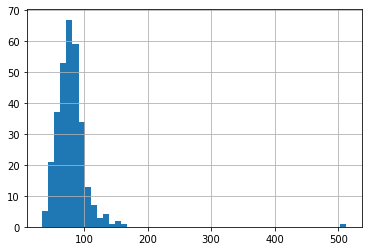

In [37]:
df_test['model_summaries_ntoks'].hist(bins=50)

In [39]:
df_test[df_test['model_summaries_ntoks']>400].model_summaries[3542]

'- Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Rain Epler, Raimond Kaljulaid, Rain Epler, Raimond Raipler, Rain Epler, Rain Epler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, Raipler, R

In [40]:
df_test.text[3542]

' \n Raimond Kaljulaid:  Austatud aseesimees! Siin me nüüd oleme, loetakse ette ajalehti ja ülistatakse elu ENSV‑s. Aga mina olen siin selleks\xa0… See oli üks eelnev kõne, sõnavõtt, mis rääkis elust ENSV‑s. Mina olen siin, et kaitsta oma head kolleegi Jevgeni Ossinovskit mõningate kolleegide rünnakute eest. Mitte ainult sellepärast, et ta on minu ülemus, minu fraktsiooni juht, vaid sellepärast, et antud juhul on tal õigus. Kõigepealt tahan öelda seda, et oli kunagi Keskerakonnal selline hea põhimõte, et seda Toompea poliitikat ei tooda all-linna. Nüüd võiks olla selline põhimõte, et seda all-linna poliitikat ei tooda Toompeale. Ega mina Sotsiaaldemokraatliku Erakonna Tallinna piirkonna juhina ka ei olnud alguses sellest eelnõust vaimustuses. Aga mul olid pikad kõnelused minister Madis Kallasega ja teiste valitsuse liikmetega. Ja ma saan aru, mis on taust. Piirkondlik majanduslik ebavõrdsus – see on suur probleem. Me peame tunnistama, et on ikka erinev küll, kas me räägime sellest, et 

In [41]:
df_test[df_test['model_summaries_ntoks']>400].summary[3542]

'- Raimond Kaljulaid räägib oma kõnes piirkondliku ebavõrdsuse vähendamisest ja toetab Jevgeni Ossinovskit.\n- Henn Põlluaas soovib vasturepliiki ja toob esile mure omavalitsuste jaoks seoses eelnõude kiire läbivaatamisega.\n- Rain Epler kõneleb omavalitsuste eelarvetest ja rõhutab vajadust leida meetmed majandusliku olukorra parandamiseks.'

In [44]:
df_test[df_test['model_summaries_ntoks']>200]

,Unnamed: 0,text,index_pk,ntoks,ntoks_space,ntoks_mbart,ntoks_gpt35,summary,ntoks_used_gpt35,split,model_summaries,model_summaries_ntoks
3542,3542,\n Raimond Kaljulaid: Austatud aseesimees! S...,PKP-651851,1840.0,1045,1830,2856,- Raimond Kaljulaid räägib oma kõnes piirkondl...,3053,test,"- Rain Epler, Rain Epler, Rain Epler, Rain Epl...",513
